In [ ]:
!pip install -qU langgraph langchain tavily-python langchain_openai langchain_community

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'
os.environ['TAVILY_API_KEY'] = 'YOUR_TAVILY_API_KEY'

# Reflexion

**Reflexion** is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its resonses for tasks to generate a higher quality final response, at the expense of longer execution time.

The Reflexion paper outlines 3 main components:
1. **Actor** (agent) with self-reflection
2. **External evaluator** (task-specific, e.g., code compilation steps)
3. **Episodic memory** that stores the reflections from Step (1).

# Define LLM

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-3.5-turbo')

# Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. Its main sub-components include:
1. Tools/tool execution
2. Initial responder: generate an initial response (and self-reflection)
3. Revisor: re-respond (and reflect) based on previous reflections

## Construct tools

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

## Initial responder

In [28]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from pydantic import ValidationError, BaseModel, Field


class Reflection(BaseModel):
    missing: str = Field(
        description='Critique of what is missing.'
    )
    superfluous: str = Field(
        description='Critique of what is superfluous'
    )


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up
    with search queries to improve the answer.
    """
    answer: str = Field(
        description="~250 word detailed answer to the question."
    )
    reflection: Reflection = Field(
        description='Your reflection on the initial answer.'
    )
    search_queries: list[str] = Field(
        description='1-3 search queries for researching improvements to address the critique of your current answer.'
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []

        for attempt in range(3): # 3 retries
            response = self.runnable.invoke(
                {'messages': state},
                {'tags': [f"attempt: {attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {'messages': response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]['id'],
                    ),
                ]

        return response

In [29]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            """You are an expert researcher.
            Current time: {time}

            1. {first_instruction}
            2. Reflect and critique your answer. Be severe to maximize improvement.
            3. Recommend search queries to research information and improve your answer.
            """,
        ),
        MessagesPlaceholder(variable_name='messages'),
        (
            'user',
            "\n\nReflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} functions.",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)


initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])

validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain,
    validator=validator,
)

In [30]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond(
    [HumanMessage(content=example_question)]
)

In [34]:
initial

{'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fALM9HEGHGk807t7uzVDQBQb', 'function': {'arguments': '{"answer":"Reflection is crucial in AI for several reasons. It allows AI systems to improve their performance by learning from past experiences and adjusting their algorithms accordingly. Through reflection, AI systems can identify errors or biases in their decision-making processes and take corrective actions to enhance their accuracy and fairness. Additionally, reflection enables AI developers to gain insights into the inner workings of the system, understand how it reached certain conclusions, and ensure transparency and accountability. By analyzing past actions and outcomes, AI systems can continuously refine their models and predictions, leading to better results and increased trust from users. Overall, reflection plays a vital role in the evolution and advancement of AI technology, promoting continuous learning, adaptation, and ethical decision-m

## Revision

In [32]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""

# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,
    cite your reflection with refences, and finally
    add search queries to improve the answer.
    """
    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])

revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [36]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial['messages'],
        ToolMessage(
            tool_call_id=initial['messages'].tool_calls[0]['id'],
            content=json.dumps(
                tavily_tool.invoke(
                    {
                        'query': initial['messages'].tool_calls[0]['args']['search_queries'][0]
                    }
                )
            )
        )
    ]
)

revised['messages']

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZcvarnxtladrV2HgGnWmKLKk', 'function': {'arguments': '{"answer":"Reflection is essential in AI as it enables systems to enhance performance by learning from past experiences, identifying errors, and ensuring transparency. For instance, AI systems can adjust algorithms based on past data to improve accuracy and fairness, fostering continuous learning and ethical decision-making. Reflection also aids developers in understanding system operations and improving user trust. By analyzing past actions, AI systems refine models, leading to better outcomes and accountability.","reflection":{"missing":"Specific examples illustrating the impact of reflection in AI would enrich the answer.","superfluous":""},"search_queries":["Examples of AI systems using reflection for improvement","Importance of self-assessment in AI development","Ethical implications of reflection in AI"],"references":["https://artificial-intelligence.ciorevie

# Create Tool Node

In [37]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries"""
    return tavily_tool.batch(
        [{'query': query} for query in search_queries]
    )


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

# Construct the Graph

In [38]:
from typing import Literal, Annotated
from typing_extensions import TypedDict

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS= 3
builder = StateGraph(State)

# add nodes
builder.add_node('draft', first_responder.respond)
builder.add_node('execute_tools', tool_node)
builder.add_node('revise', revisor.respond)

# add edges
builder.add_edge(START, 'draft')
# draft -> execute_tools
builder.add_edge('draft', 'execute_tools')
# execute_tools -> revise
builder.add_edge('execute_tools', 'revise')

# define looping logic
def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {'tool', 'ai'}:
            break
        i += 1

    return i

def event_loop(state: list):
    # in our case, we just stop after N plans
    num_iterations = _get_num_iterations(state['messages'])

    if num_iterations > MAX_ITERATIONS:
        return END

    return 'execute_tools'

# revise -> execute_tools OR end
builder.add_conditional_edges(
    'revise',
    event_loop,
    ['execute_tools', END],
)

graph = builder.compile()

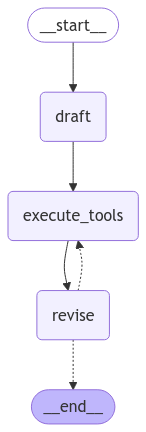

In [39]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
events = graph.stream(
    {"messages": [("user", "How should we handle the climate crisis?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()